In [1]:
from utils import *
from brain_seg import motor_sensory_ind
from scipy.stats import spearmanr
from scipy.io import savemat
import dask.array as da
import dask.dataframe as ddf
%load_ext autoreload
%autoreload 2

df = pd.read_csv('../Processing/data_list.csv')
row = df.iloc[5]
save_root = row['save_dir']+'/'
print(row['dat_dir'])

brain_map = np.load(save_root+'Y_ave.npy')
trans_ = np.load(save_root+'trans_affs.npy')
processed_dir = row['dat_dir'] + 'processed/'
CL_path = processed_dir + 'CL_trials.pkl'
OL_path = processed_dir + 'OL_trials.pkl'

/nrs/ahrens/jing/state_modulation/LG_vs_NGGU/20191130/fish00/6dpf_HuC-GC7FF_GU-fwd_fish00_exp02_20191130_151303/


### Check if all time points were valid in registration

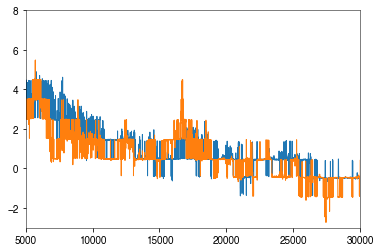

In [2]:
plt.plot(trans_[:, 1, -1])
plt.plot(trans_[:, 2, -1])
plt.ylim([-3, 8])
t_max=30000
t_min=5000
plt.xlim([t_min, t_max])
plt.show()

In [3]:
%%time
_ = np.load(save_root+'cell_dff.npz', allow_pickle=True)
A = _['A']
A_loc = _['A_loc']
dFF = _['dFF'].astype('float')
_ = None

CPU times: user 34.9 s, sys: 17.3 s, total: 52.1 s
Wall time: 52.3 s


#### Compute cell center

In [4]:
print(save_root)

/nrs/ahrens/Ziqiang/Jing_Glia_project/Processed_data/20191130/fish00/6dpf_HuC-GC7FF_GU-fwd_fish00_exp02_20191130_151303//


In [5]:
if not os.path.exists(save_root+'cell_center.npy'):
    A_center = np.zeros((dFF.shape[0],3))
    (X,Y) = np.meshgrid(np.arange(100),np.arange(100))
    for n_, A_ in enumerate(A):
        A_loc_ = A_loc[n_]
        z, x, y = A_loc_
        A_[A_<A_.max()*0.4]=0
        cx = (X*A_).sum()/A_.sum()
        cy = (Y*A_).sum()/A_.sum()
        A_center[n_]=np.array([z, x+cx, y+cy])
    savemat(save_root+'cell_center.mat', {'z':A_center[:,0],'x':A_center[:,1], 'y':A_center[:,2]})
    np.save(save_root+'cell_center.npy', A_center)
A_center = np.load(save_root+'cell_center.npy')

#### Get active cells

In [6]:
if not os.path.exists(save_root+'motor_sensory_ind.npz'):
    motor_sensory_ind(row, t_range=(t_min, t_max))

In [7]:
_ = np.load(save_root+'motor_sensory_ind.npz', allow_pickle=True)
motor_time=_['motor_time']
sensory_time=_['sensory_time']
motor_valid=_['motor_valid']
motor_corr=_['motor_corr']
sensory_valid=_['sensory_valid']
sensory_corr=_['sensory_corr']

#### Reduce analyses to sensory and motor active neurons

In [8]:
sensory_ind = (sensory_valid>25)| (motor_valid>25)
sensory_ind.mean()

0.9964309490346919

In [9]:
dFF=dFF[sensory_ind][:, t_min:t_max]
A=A[sensory_ind]
A_loc=A_loc[sensory_ind]
A_center = A_center[sensory_ind]

In [10]:
num_z=A_center[:,0].max().astype('int')

### get ranked data for spearmen correlation computing

In [28]:
from sklearn.decomposition import FactorAnalysis

In [29]:
dFFz=dFF[A_center[:,0]==0]
dFFz=(dFFz-dFFz.mean(axis=-1,keepdims=True))/dFFz.std(axis=-1,keepdims=True)

In [74]:
FA_=FactorAnalysis(n_components=10, svd_method='randomized',random_state=None) 

In [75]:
%%time
FA_.fit(dFFz.T)

CPU times: user 6.9 s, sys: 630 ms, total: 7.53 s
Wall time: 7.55 s


FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=10,
               noise_variance_init=None, random_state=None,
               svd_method='randomized', tol=0.01)

In [115]:
valid_cell=FA_.noise_variance_<0.8

In [116]:
corr_z, _=spearmanr(dFFz[valid_cell], axis=1)

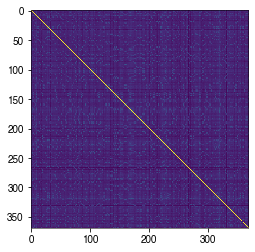

In [117]:
plt.imshow(corr_z)

In [118]:
%%time
FA_.fit(dFFz[valid_cell].T)

CPU times: user 720 ms, sys: 85 ms, total: 805 ms
Wall time: 805 ms


FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=10,
               noise_variance_init=None, random_state=None,
               svd_method='randomized', tol=0.01)

In [125]:
lam=FA_.components_.T

In [120]:
from factor_analyzer import Rotator
Rot_=Rotator(power=4)
loadings, rotation_mtx, phi=Rot_._promax(lam)

In [147]:
np.abs(loadings-np.matmul(lam, rotation_mtx)).sum()

1.3260563030666542e-13

In [150]:
np.abs(np.matmul(np.matmul(rotation_mtx, phi), rotation_mtx.T)-np.eye(10)).sum()

3.162785801654255e-14

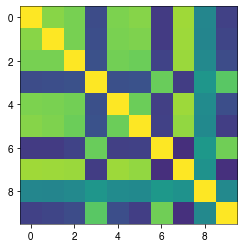

In [124]:
plt.imshow(phi, vmax=1, vmin=-1)

In [152]:
x_new=FA_.transform(dFFz[valid_cell].T).T
x_new=np.matmul(np.linalg.inv(rotation_mtx), x_new)

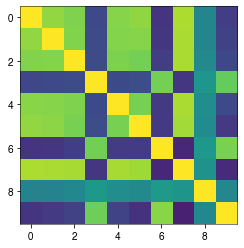

In [162]:
cov_ = np.matmul(x_new,x_new.T)
cov_ = cov_/np.diag(cov_)[:,np.newaxis]
plt.imshow(cov_, vmax=1, vmin=-1)

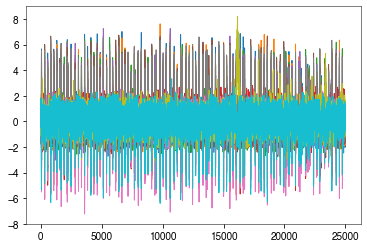

In [157]:
plt.plot(x_new.T)
plt.show()

##### Rank correlation -- compute rank

In [13]:
%%time
dFF_r_t = dFF_r.T

CPU times: user 9 µs, sys: 14 µs, total: 23 µs
Wall time: 30.5 µs


In [14]:
import mkl
mkl.set_num_threads(96)
print(f'Test thread at: {mkl.get_max_threads()}')
import numpy as np

Test thread at: 48


In [ ]:
%%time
dFF_r_corr=np.matmul(dFF_r, dFF_r_t)
dFF_r_corr=dFF_r_corr/dFF_r.shape[1]

In [ ]:
dFF_r_corr.shape

In [ ]:
plt.imshow(dFF_r_corr, vmax=1, vmin=0)
plt.show()

In [ ]:
%%time
corr_, _ = spearmanr(dFF, axis=1)

(0, 10)

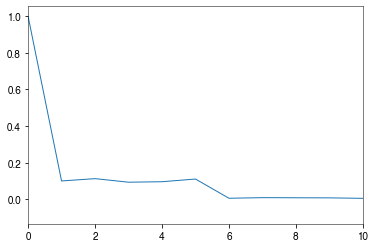

In [18]:
plt.plot(dFF_r_corr[0])
plt.xlim([0, 10])

In [27]:
h_corr = (dFF_r_corr>0.25).sum(axis=-1)

In [29]:
h_corr.min()

1

In [33]:
corr_.shape

NameError: name 'corr_' is not defined

In [ ]:
import fish_proc.wholeBrainDask.cellProcessing_single_WS as fwc
import dask.array as da
dask_tmp = '/scratch/weiz/dask-worker-space'
memory_limit = 0 # unlimited
cluster, client = fwc.fdask.setup_workers(is_local=True, dask_tmp=dask_tmp, memory_limit=memory_limit)

In [18]:
dFF_r=da.from_array(dFF_r, chunks=(1000,-1))
da.einsum('ij,kj->ik', dFF_r, dFF_r).to_zarr('/scratch/weiz/dFF_r_corr.zarr')
dFF_r_corr=da.from_zarr('/scratch/weiz/dFF_r_corr.zarr')

KeyboardInterrupt: 

In [9]:
if not os.path.exists(save_root+'sub_corr_matrix.npz'):
    num_z = A_loc[:,0].max()+1
    # compute layer by layer correlations and remove some cells
    valid_cell = []
    for nz in tqdm(range(num_z)):
        layer_cells = np.where(A_loc[:,0]==nz)[0]
        corr_, _ = spearmanr(dFF[layer_cells], axis=1)
        st_sensory_ind=((np.abs(corr_)>0.3).sum(axis=-1)>10)
        valid_cell.append(layer_cells[st_sensory_ind])
    valid_cell=np.concatenate(valid_cell)
    corr_, _ = spearmanr(dFF[valid_cell], axis=1)
    np.savez(save_root+'sub_corr_matrix.npz', corr=corr_, valid_cell=valid_cell)
_ = np.load(save_root+'sub_corr_matrix.npz', allow_pickle=True)
corr_=_['corr']
valid_cell=_['valid_cell']

In [ ]:
pdist = spc.distance.pdist(corr_)

In [ ]:
num_cluster = 25
linkage = spc.linkage(pdist, method='ward', optimal_ordering=True) # complete
linkage = spc.linkage(pdist, method='complete') # complete
idx = spc.fcluster(linkage, num_cluster, 'maxclust')
# idx = spc.fcluster(linkage, linkage.max()*0.1, 'distance')
sort_ = np.argsort(idx)

plt.figure()
plt.matshow(corr_[sort_][:,sort_], vmax=0.5, vmin=0, cmap='gray_r')
plt.show()

In [ ]:
idx_ = np.zeros(A_loc.shape[0]).astype('int')
idx_[valid_cell]=idx

for nplot in range(1, num_cluster+1):
    plt.figure(figsize=(6, 4))
    plt.imshow(brain_map.astype('float').max(axis=0).squeeze(), cmap='gray')
    plt.scatter(A_center[idx_==nplot,2],A_center[idx_==nplot,1], [], c=A_center[idx_==nplot,0], cmap=plt.cm.nipy_spectral, vmax=30, vmin=0, alpha=0.5)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

#### NMF

In [1]:
from scipy.sparse import csr_matrix
from sklearn.decomposition import NMF

In [ ]:
snmf_dFF=dFF-np.percentile(dFF, 1, axis=-1, keepdims=True)

In [ ]:
num_cell=sensory_ind.sum()
snmf_dFF[snmf_dFF<0]=0
Yt_r = csr_matrix(snmf_dFF);
model = NMF(n_components=1, init='custom')

In [ ]:
U_mat = []
V_mat = []

idx_max = sA_corr_label.max()+1
for nidx in range(idx_max):
    comp = sA_scorr_label==nidx
    y_temp = Yt_r[comp, :]
    if y_temp.sum()==0:
        continue
    u_ = np.zeros((num_cell,1)).astype('float32')
    u_[comp] = model.fit_transform(y_temp, W=np.array(y_temp.mean(axis=1)),H = np.array(y_temp.mean(axis=0)))
    U_mat.append(u_)
    V_mat.append(model.components_.T)

In [ ]:
idx_max = sA_scorr_label.max()+1
for nidx in range(idx_max):
    comp = sA_scorr_label==nidx
    y_temp = Yt_r[comp, :]
    if y_temp.sum()==0:
        continue
    u_ = np.zeros((num_cell,1)).astype('float32')
    u_[comp] = model.fit_transform(y_temp, W=np.array(y_temp.mean(axis=1)),H = np.array(y_temp.mean(axis=0)))
    U_mat.append(u_)
    V_mat.append(model.components_.T)

In [ ]:
U_mat_ = np.array(U_mat, order='F').squeeze().T
V_mat_ = np.array(V_mat, order='F').squeeze().T
model_ = NMF(n_components=U_mat_.shape[-1], init='custom', solver='cd', max_iter=30, verbose=True)
U = model_.fit_transform(Yt_r.astype('float64'), W=U_mat_.astype('float64'), H=V_mat_.T.astype('float64'))

In [ ]:
np.savez(save_root+'sensory_cells.npz', sA_center=sA_center, sA_corr_label=sA_corr_label, sA_scorr_label=sA_scorr_label, U=U)

In [ ]:
# U_ = U/np.linalg.norm(U, ord=2, axis=0)

In [ ]:
brain_map = np.load(save_root+'Y_ave.npy').squeeze().astype('float')
brain_comp = np.zeros(brain_map.shape)

In [ ]:
xind = sA_center[:,0]==11
plt.imshow(brain_map.max(axis=0), cmap='gray')
plt.scatter(sA_center[xind, 2]-64, sA_center[xind, 1]-64, np.ones(xind.sum())*8, U[xind, 3])
plt.show()

In [ ]:
fig, ax = plt.subplots(4, 6, figsize=(20, 10), sharex=True, sharey=True)
ax = ax.flatten()

for ncomp in range(22):
    ax[ncomp].imshow(brain_map.max(axis=0), cmap='gray')
    u_ = U[:, ncomp]
    u_[u_<u_.max()*0.3]=0
    ax[ncomp].scatter(sA_center[u_>0, 2]-64, sA_center[u_>0, 1]-64, np.ones((u_>0).sum())*8, u_[u_>0])
    ax[ncomp].set_axis_off()

ax[ncomp].set_xlim([0, brain_map.shape[2]])
ax[ncomp].set_ylim([0, brain_map.shape[1]])
plt.tight_layout()
plt.show()

### sensory cells and index

In [ ]:
sA_center=A_center[sensory_ind]
sA_corr_label=np.zeros(sensory_ind.sum()).astype('int')
sA_scorr_label=np.zeros(sensory_ind.sum()).astype('int')
st_sensory_ind=((np.abs(corr_)>0.4).sum(axis=-1)>10)
sA_corr_label[st_sensory_ind]=idx+1
st_sensory_ind=((np.abs(scorr_)>0.3).sum(axis=-1)>10)
sA_scorr_label[st_sensory_ind]=sidx+1

In [ ]:
np.savez(save_root+'sensory_cells.npz', sA_center=sA_center, sA_corr_label=sA_corr_label, sA_scorr_label=sA_scorr_label)

In [ ]:
save_root

In [ ]:
_=np.load(save_root+'sensory_cells.npz', allow_pickle=True)
sA_center=_['sA_center']
sA_corr_label=_['sA_corr_label']
sA_scorr_label=_['sA_scorr_label']


from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sA_center[sA_corr_label>0, 1], sA_center[sA_corr_label>0, 2], sA_center[sA_corr_label>0, 0], c=sA_corr_label[sA_corr_label>0], cmap=plt.cm.nipy_spectral)
plt.show()


from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sA_center[sA_scorr_label>0, 1], sA_center[sA_scorr_label>0, 2], sA_center[sA_scorr_label>0, 0], c=sA_corr_label[sA_scorr_label>0], cmap=plt.cm.nipy_spectral)
plt.show()


from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.voxels(sA_center[sA_scorr_label>0, 1], sA_center[sA_scorr_label>0, 2], sA_center[sA_scorr_label>0, 0], sA_corr_label[sA_scorr_label>0])
plt.show()

### Motor active neurons

### remove white-noise like cells from analyses

### NMF

In [ ]:
nmf_ = NMF(n_components=200, max_iter=2000, verbose=True)

In [ ]:
from scipy.sparse import csr_matrix

In [ ]:
X = dFF - np.percentile(dFF, 1, axis=-1, keepdims=True)
dFF = None
X_sparse = X.copy()
X_sparse[X_sparse<=0]=0
X_sparse = csr_matrix(X_sparse)

In [ ]:
dFF = None
X = None

In [ ]:
def sparse_corrcoef(A):
    n = A.shape[-1]
    rowsum = A.sum(axis=-1)
    c_ = rowsum.dot(rowsum.T)/n
    C = (A.dot(A.T) - C)/(n-1)
    d = np.diag(C)
    return C/np.sqrt(np.outer(d, d))